In [1]:
import os
from collections import Counter
from IPython import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchaudio

from torchvision import transforms
from torchvision import models

import librosa

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
display.Audio('./audio/1-137-A-32.wav')

In [3]:
counter = Counter()
for root, _, files in os.walk('./audio'):
    items = [file.split('-')[-1].split('.')[0] for file in files]
    items2 = [(os.path.join(root, file),file.split('-')[-1].split('.')[0])  for file in files]
counter.update(items)
counter

Counter({'22': 40,
         '16': 40,
         '9': 40,
         '47': 40,
         '42': 40,
         '21': 40,
         '11': 40,
         '36': 40,
         '30': 40,
         '49': 40,
         '43': 40,
         '31': 40,
         '3': 40,
         '45': 40,
         '23': 40,
         '5': 40,
         '46': 40,
         '37': 40,
         '14': 40,
         '15': 40,
         '39': 40,
         '48': 40,
         '2': 40,
         '44': 40,
         '18': 40,
         '25': 40,
         '41': 40,
         '13': 40,
         '28': 40,
         '19': 40,
         '40': 40,
         '29': 40,
         '35': 40,
         '4': 40,
         '38': 40,
         '7': 40,
         '10': 40,
         '33': 40,
         '12': 40,
         '34': 40,
         '1': 40,
         '27': 40,
         '17': 40,
         '6': 40,
         '20': 40,
         '0': 40,
         '8': 40,
         '26': 40,
         '32': 40,
         '24': 40})

In [4]:
class ESC50Dataset(Dataset):
    def __init__(self, files:list, labels:list):
        self.files = files
        self.labels = labels


    def __getitem__(self, index):
        filename = self.files[index]
        audio_tensor, _ = torchaudio.load(filename)
        return audio_tensor, torch.tensor(self.labels[index])
        

    def __len__(self):
        return len(self.labels)

In [5]:
def get_files_labels(path:str='./audio') -> tuple[list[str], list[int]]:
    filenames = []
    labels = []
    for root, _, files in os.walk(path):
        for file in files:
            filenames.append(os.path.join(root, file))
            labels.append(int(file.split('-')[-1].split('.')[0]))
    return filenames, labels

filenames, labels = get_files_labels()

train_files, temp_files, train_labels, temp_labels = train_test_split(filenames, labels, test_size=0.2, random_state=42, stratify=labels)

val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

train_data = ESC50Dataset(train_files, train_labels)
val_data = ESC50Dataset(val_files, val_labels)
test_data = ESC50Dataset(test_files, test_labels)

batch_size = 16
num_workers = 0
train_loader = DataLoader(train_data, shuffle=True, num_workers=num_workers, batch_size=batch_size)
val_loader = DataLoader(val_data, num_workers=num_workers, batch_size=batch_size)
test_loader = DataLoader(test_data, num_workers=num_workers, batch_size=batch_size)

In [6]:
len(val_data)

200

In [7]:
class AudioNet(nn.Module):
    def __init__(self):
        super(AudioNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 80, 4)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.avgPool = nn.AvgPool1d(30)
        self.fc1 = nn.Linear(512, 10)

        self.pool = nn.MaxPool1d(4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.mean(dim=2)
        x = self.fc1(x)

        return F.log_softmax(x, dim=1)

In [8]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

In [9]:
audionet = AudioNet()
audionet.to(device)
optimizer = optim.Adam(audionet.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()


In [ ]:
def train(model=audionet, train_loader=train_loader, val_loader=val_loader, loss_fn=criterion, optimizer=optimizer, device=device, epochs=20):
    for epoch in range(1,epochs+1):
        train_loss, val_loss = 0.0, 0.0
        model.train()
        for inputs, target in train_loader:
            optimizer.zero_grad()
            inputs, target = inputs.to(device), target.to(device)
            output = model(inputs)
            loss = loss_fn(output, target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_loss /= len(train_loader)

        correct, num_sample = 0.0, 0.0
        model.eval()
        for inputs, target in val_loader:
            inputs, target = inputs.to(device), target.to(device)
            output = model(inputs)
            loss = loss_fn(output, target)
            val_loss += loss.item()

            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            num_sample += target.size(0)
        val_loss /= len(val_loader)

        print(f"Epoch: {epoch}, Train Loss: {train_loss:.2f}, Validation Loss: {val_loss:.2f}, Accuracy: {(correct/num_sample):.2f}")


In [ ]:
train(model=audionet, optimizer=optimizer, loss_fn=criterion, train_loader=train_loader, val_loader=val_loader)

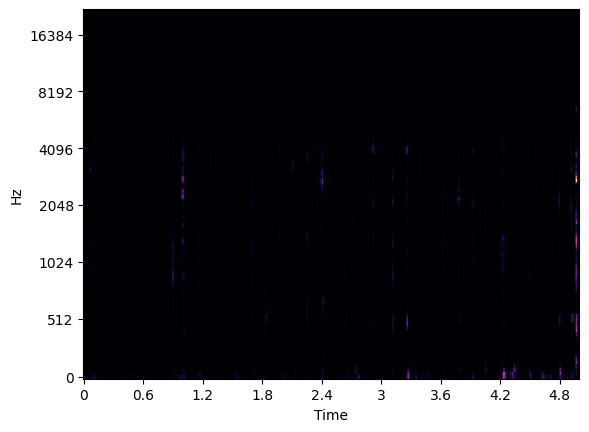

In [11]:
sample_data, sr = librosa.load('./audio/1-137-A-32.wav', sr=None)
spectogram = librosa.feature.melspectrogram(y=sample_data, sr=sr)
librosa.display.specshow(spectogram, sr=sr, x_axis='time', y_axis='mel')
plt.show()

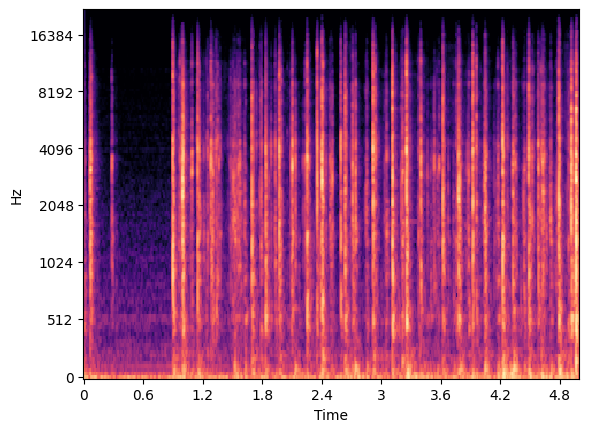

In [12]:
log_spectrogram = librosa.power_to_db(spectogram, ref=np.max)
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.show()

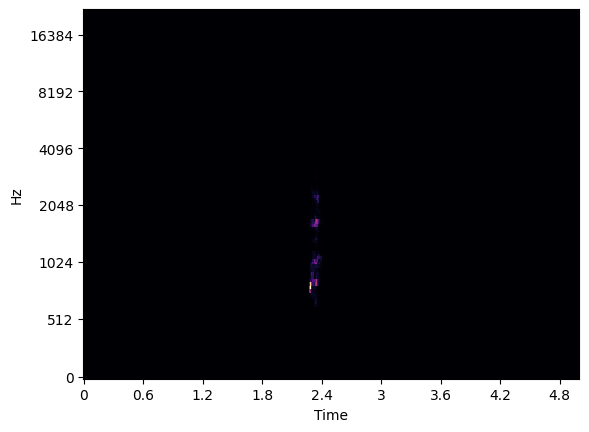

In [13]:
sample_data, sr = librosa.load('./audio/1-100032-A-0.wav', sr=None)
spectogram = librosa.feature.melspectrogram(y=sample_data, sr=sr)
librosa.display.specshow(spectogram, sr=sr, x_axis='time', y_axis='mel')
plt.show()

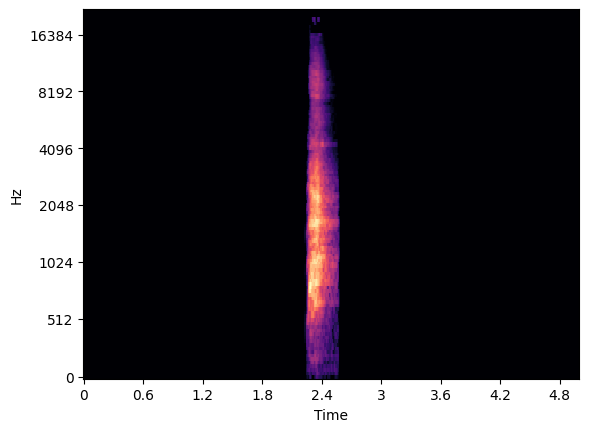

In [14]:
log_spectrogram = librosa.power_to_db(spectogram, ref=np.max)
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.show()

In [15]:
class ESC50RGBSpectrogramDataset(Dataset):
    def __init__(self, filenames: list, labels: list, sr: int = 22050, n_mels: int = 128, duration: float = 5.0, image_size: int = 224):
        self.filenames = filenames
        self.labels = labels
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.samples = int(sr * duration)
        self.image_size = image_size

        # Transform to resize and convert to tensor
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),  # Converts to [0, 1] and shape (3, H, W)
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        filename = self.filenames[index]
        label = self.labels[index]

        # Load audio
        audio, sr = librosa.load(filename, sr=self.sr, duration=self.duration)

        # Pad or trim to fixed length
        if len(audio) < self.samples:
            audio = np.pad(audio, (0, self.samples - len(audio)))
        else:
            audio = audio[:self.samples]

        # Generate mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=self.n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize to [0, 255] and convert to uint8
        log_mel_spec -= log_mel_spec.min()
        log_mel_spec /= log_mel_spec.max()
        log_mel_spec *= 255.0
        log_mel_spec = log_mel_spec.astype(np.uint8)

        # Convert to RGB by stacking
        rgb_image = np.stack([log_mel_spec] * 3, axis=-1)  # Shape: (H, W, 3)
        pil_image = Image.fromarray(rgb_image)

        # Apply transform
        image_tensor = self.transform(pil_image)

        return image_tensor, torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

In [16]:
train_data = ESC50RGBSpectrogramDataset(train_files, train_labels)
val_data = ESC50RGBSpectrogramDataset(val_files, val_labels)
test_data = ESC50RGBSpectrogramDataset(test_files, test_labels)

batch_size = 16
num_workers = 0
train_loader = DataLoader(train_data, shuffle=True, num_workers=num_workers, batch_size=batch_size)
val_loader = DataLoader(val_data, num_workers=num_workers, batch_size=batch_size)
test_loader = DataLoader(test_data, num_workers=num_workers, batch_size=batch_size)

In [17]:
resnet = models.resnet50(weights='IMAGENET1K_V2')
for name, params in resnet.named_parameters():
    if 'bn' in name:
        params.requires_grad = True
    else:
        params.requires_grad = False

resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 500),
    nn.ReLU(),
    nn.Linear(500, 50)
)


In [18]:
resnet.to(device)
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [19]:
train(model=resnet, optimizer=optimizer, loss_fn=criterion, train_loader=train_loader, val_loader=val_loader)

Epoch: 1, Train Loss: 3.26, Validation Loss: 2.25, Accuracy: 0.39
Epoch: 2, Train Loss: 1.82, Validation Loss: 1.52, Accuracy: 0.57
Epoch: 3, Train Loss: 1.22, Validation Loss: 1.18, Accuracy: 0.65
Epoch: 4, Train Loss: 0.89, Validation Loss: 1.02, Accuracy: 0.66
Epoch: 5, Train Loss: 0.64, Validation Loss: 0.90, Accuracy: 0.71
Epoch: 6, Train Loss: 0.54, Validation Loss: 0.83, Accuracy: 0.74
Epoch: 7, Train Loss: 0.38, Validation Loss: 0.92, Accuracy: 0.70
Epoch: 8, Train Loss: 0.36, Validation Loss: 0.73, Accuracy: 0.79
Epoch: 9, Train Loss: 0.27, Validation Loss: 0.73, Accuracy: 0.77
Epoch: 10, Train Loss: 0.22, Validation Loss: 0.80, Accuracy: 0.79
Epoch: 11, Train Loss: 0.17, Validation Loss: 0.69, Accuracy: 0.78
Epoch: 12, Train Loss: 0.15, Validation Loss: 0.75, Accuracy: 0.75
Epoch: 13, Train Loss: 0.16, Validation Loss: 0.82, Accuracy: 0.74
Epoch: 14, Train Loss: 0.16, Validation Loss: 0.72, Accuracy: 0.76
Epoch: 15, Train Loss: 0.13, Validation Loss: 0.64, Accuracy: 0.78
Epoc